# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import re
import nltk

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [5]:
train['keyword'] = np.where(train['keyword'].isnull(), '', train['keyword'])
test['keyword'] = np.where(test['keyword'].isnull(), '', test['keyword'])
train['location'] = np.where(train['location'].isnull(), '', train['location'])
test['location'] = np.where(test['location'].isnull(), '', test['location'])
test

,id,keyword,location,text,target
2644,3796,destruction,,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
4307,6115,hellfire,"570 Vanderbilt; Brooklyn, NY",New cocktail on the list! El Diablo Mas Verde:...,0
3375,4833,evacuation,USA,Bend Post Office roofers cut gas line prompt e...,1
1710,2466,collided,,Monsoon flooding - Monsoon rains have have hit...,1
4898,6973,massacre,Ireland,Remember this was a massacre of civilians. #Hi...,1


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [134]:
values = train['target'].value_counts()
values[1] / values[0]

0.7622354497354498

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [7]:
popular_keywords = data['keyword'].value_counts().index[:10]
most_popular = data[data['keyword'].isin(popular_keywords)]
most_popular

,id,keyword,location,text,target
304,446,armageddon,"California, United States",#PBBan (Temporary:300) avYsss @'aRmageddon | D...,0
305,447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0
306,448,armageddon,#FLIGHTCITY UK,((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...,0
307,450,armageddon,NaN,ouvindo Peace Love &amp; Armageddon,0
308,451,armageddon,NaN,Best movie you've ever seen? - Armageddon htt...,0
...,...,...,...,...,...
6121,8737,sinking,London,Slowly sinking wasting ?? @edsheeran,0
6122,8738,sinking,Rhyme Or Reason?,The #Tribe just keeps sinking everyday it seem...,1
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1
6124,8740,sinking,hey Georgia,each time we try we always end up sinking,0


In [294]:
most_popular['keyword'].unique()

array(['armageddon', 'body%20bags', 'damage', 'deluge', 'evacuate',
       'fatalities', 'fear', 'harm', 'outbreak', 'sinking'], dtype=object)

<Axes: xlabel='keyword', ylabel='Count'>

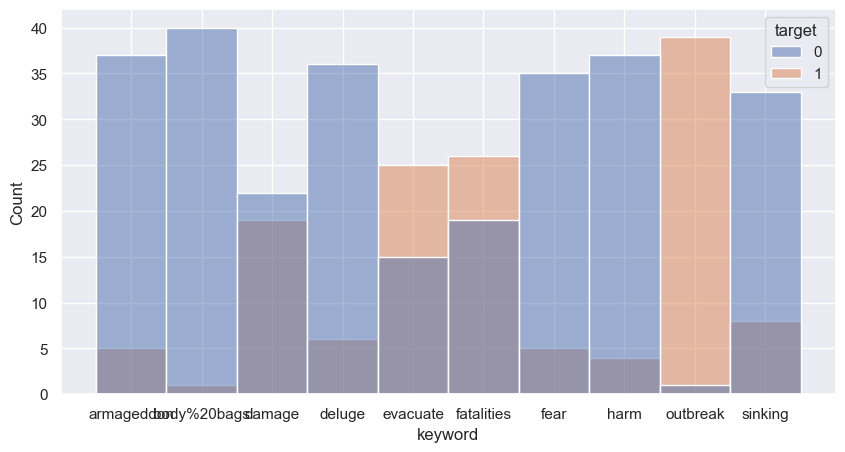

In [8]:
sns.set_theme()
sns.set(rc={"figure.figsize":(10, 5)})
sns.histplot(data=most_popular, x='keyword', hue='target')

**Выводы**: получается, фейковых новостей в целом больше, чем правдивых, кроме случаев о выспышках заболеваний (outbreak), а также эвакуациях (evacuate) и смертельных исходах (fatalities). Новости с ключевыми словами armageddon, body bags, harm, fear, deluge в большинстве своём фейковые.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [9]:
train['text'] = train['keyword'] + train['location'] + train['text']
test['text'] = test['keyword'] + test['location'] + test['text']

train_new = train.drop(['id', 'keyword', 'location'], axis=1)
test_new = test.drop(['id', 'keyword', 'location'], axis=1)

In [54]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivorsMarietta, GAsurvivorsMarietta, GAsurv...",1
7122,violent%20stormviolent%20stormviolent%20stormI...,1
2769,devastationAtlanta g.a.devastationAtlanta g.a....,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(analyzer='word', encoding='utf-8')
x_train = vectorize.fit_transform(train_new['text'].values)

In [11]:
vocab = vectorize.vocabulary_
vocab

{'bridge': 4091,
 '20collapseashes': 504,
 '2015': 297,
 'australia': 2943,
 'ûªs': 22707,
 'collapse': 5237,
 'at': 2820,
 'trent': 20306,
 'among': 2350,
 'worst': 21971,
 'in': 11061,
 'history': 10473,
 'england': 7870,
 'bundled': 4222,
 'out': 15090,
 'for': 9084,
 '60': 1403,
 'http': 10695,
 'co': 5182,
 't5trhjuau0': 19380,
 'hailcarol': 9993,
 'stream': 18995,
 'illinoisgreat': 10989,
 'michigan': 13511,
 'technique': 19526,
 'camp': 4474,
 'b1g': 3074,
 'thanks': 19699,
 'to': 20008,
 'bmurph1019': 3851,
 'hail_youtsey': 9986,
 'termn8r13': 19586,
 'goblue': 9674,
 'wrestleon': 22109,
 'oaskgki6qj': 14664,
 'policehouston': 15805,
 'cnn': 5175,
 'tennessee': 19568,
 'movie': 13876,
 'theater': 19710,
 'shooting': 18069,
 'suspect': 19282,
 'killed': 12076,
 'by': 4323,
 'police': 15800,
 'di8elzswnr': 6877,
 'riotingstill': 17117,
 'rioting': 17099,
 'couple': 5651,
 'of': 14773,
 'hours': 10651,
 'left': 12510,
 'until': 20834,
 'have': 10159,
 'be': 3318,
 'up': 20845,
 'c

In [292]:
x_train.shape

(5329, 23874)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [12]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.findall(r'\d+', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return bool(re.findall(r'[^\w\s]+', s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    digit_count = 0
    punct_count = 0
    hash_count = 0
    ment_count = 0
    for token in vocabulary:
        digit_count += 1 if contains_digit(token) else 0
        punct_count += 1 if contains_punctuation(token) else 0
        hash_count += 1 if is_hashtag(token) else 0
        ment_count += 1 if is_mention(token) else 0
    print('With digit:      ', digit_count
          )
    print('With punctuation:', punct_count
          )
    print('Hashtags:        ', hash_count
          )
    print('Mentions:        ', ment_count
          )




In [13]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [14]:
investigate_vocabulary(vocab)

With digit:       4590
With punctuation: 0
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [15]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [16]:
vectorize = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
x_train = vectorize.fit_transform(train_new['text'])
token_vocab = vectorize.vocabulary_
token_vocab

C:\Users\vchemsmisl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


{'bridge': 6424,
 '%': 1476,
 '20collapseashes': 1988,
 '2015': 1779,
 ':': 2899,
 'australia': 5528,
 '\x89': 23793,
 'ûªs': 23843,
 'collapse': 7361,
 'at': 5427,
 'trent': 22212,
 'among': 5041,
 'worst': 23461,
 'in': 15248,
 'history': 11636,
 'england': 9558,
 'bundled': 6531,
 'out': 18018,
 'for': 10613,
 '60': 2744,
 '...': 1515,
 'http://t.co/t5trhjuau0': 14139,
 'hailcarol': 11225,
 'stream': 21126,
 ',': 1487,
 'illinoisgreat': 15192,
 'michigan': 16922,
 'technique': 21600,
 'camp': 6729,
 'b1g': 5630,
 'thanks': 21750,
 'to': 21961,
 '@bmurph1019': 3161,
 '@hail_youtsey': 3575,
 '.': 1513,
 '@termn8r13': 4387,
 '#goblue': 521,
 '#wrestleon': 1445,
 'http://t.co/oaskgki6qj': 13685,
 'policehouston': 18588,
 'cnn': 7311,
 'tennessee': 21636,
 'movie': 17214,
 'theater': 21756,
 'shooting': 20342,
 'suspect': 21399,
 'killed': 15897,
 'by': 6619,
 'police': 18581,
 'http://t.co/di8elzswnr': 12604,
 'riotingstill': 19606,
 'rioting': 19588,
 'a': 4612,
 'couple': 7751,
 'of':

In [17]:
investigate_vocabulary(token_vocab)

With digit:       4609
With punctuation: 7544
Hashtags:         1474
Mentions:         1678


**Сравнение:** Получается, дефолтное преобразование текстовых значений в векторы игнорирует знаки препинания, что устраняется внедрением токенизатора. Также можно заметить, что незначительно отличается число токенов с числами, выделенных обоими векторизаторами.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [18]:
tokenizer = TweetTokenizer()

In [19]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vchemsmisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [233]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return bool(re.fullmatch(r'[a-z]+', s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return bool(re.fullmatch(r'[^\w\s]+\s?[^\w\s]?\s?[)()]+', s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    clean_tokens = []
    for token in tokens:
        if token in nltk.corpus.stopwords.words('english'):
            continue
        if contains_only_latin_letters(token) or \
        is_emoji(token) or is_hashtag(token):
            stem_token = stemmer.stem(token)
            clean_tokens.append(stem_token)
    return clean_tokens 
  

In [234]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [235]:
train['text'][:10].map(custom_tokenizer)

1186    [bridg, australia, collaps, trent, bridg, amon...
4071    [hailcarol, stream, illinoisgreat, michigan, t...
5461    [policehouston, cnn, tennesse, movi, theater, ...
5787        [riotingstil, riot, coupl, hour, left, class]
7445    [woundslak, highlandscrack, path, wipe, morn, ...
151     [airplan, thereexpert, franc, begin, examin, a...
915     [bloodyisol, citi, world, came, kill, indian, ...
1305                    [burn, except, idk, realli, burn]
2570                       [destroyh, ask, destroy, hous]
7399    [woundedmaracay, nirgua, venezuelapolic, offic...
Name: text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [118]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
train_vec = vectorizer.fit_transform(train_new['text']).toarray()
test_vec = vectorizer.transform(test_new['text']).toarray()

C:\Users\vchemsmisl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [119]:
train_vec.shape, test_vec.shape

((5329, 13970), (2284, 13970))

2. Обучите LogisticRegression на полученных признаках.


In [120]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vec, train_new['target'])
predict = logreg.predict(test_vec)

3. Посчитайте метрику f1-score на тестовых данных.

In [121]:
from sklearn.metrics import f1_score
f'F1 score: {f1_score(test["target"], predict)}'

'F1 score: 0.7422907488986784'

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
train_vec = vectorizer.fit_transform(train_new['text']).toarray()
test_vec = vectorizer.transform(test_new['text']).toarray()

logreg = LogisticRegression()
logreg.fit(train_vec, train_new['target'])
predict = logreg.predict(test_vec)

f'F1 score: {f1_score(test["target"], predict)}'

C:\Users\vchemsmisl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'F1 score: 0.7319294251565169'

1. **Ответ:** F1 score немного упал, т.е. качество модели ухудшилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [139]:
# 2
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
train_vec1 = vectorizer.fit_transform(train_new['text']).toarray()
test_vec1 = vectorizer.transform(test_new['text']).toarray()

logreg = LogisticRegression()
logreg.fit(train_vec1, train_new['target'])
predict = logreg.predict(test_vec1)

f'F1 score: {f1_score(test["target"], predict)}'

'F1 score: 0.7319294251565169'

In [140]:
train_vec1.shape, test_vec1.shape

((5329, 13970), (2284, 13970))

2. **Ответ:** Качество модели не изменилось, размер тоже не поменялся

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [214]:
# 3
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.0005)
train_vec = vectorizer.fit_transform(train_new['text']).toarray()
test_vec = vectorizer.transform(test_new['text']).toarray()

logreg = LogisticRegression()
logreg.fit(train_vec, train_new['target'])
predict = logreg.predict(test_vec)

f'F1 score: {f1_score(test["target"], predict)}'

C:\Users\vchemsmisl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'F1 score: 0.7325056433408578'

In [215]:
train_vec.shape, test_vec.shape

((5329, 2930), (2284, 2930))

3. **Ответ:** Качество почти не меняется 

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [199]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
train_vec = vectorizer.fit_transform(train_new['text']).toarray()
test_vec = vectorizer.transform(test_new['text']).toarray()

logreg = LogisticRegression()
logreg.fit(train_vec, train_new['target'])
predict = logreg.predict(test_vec)

f'F1 score: {f1_score(test["target"], predict)}'

C:\Users\vchemsmisl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'F1 score: 0.709494030699261'

2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Подход с CountVectorizer

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [293]:
vectorizer = CountVectorizer()
train_vec = vectorizer.fit_transform(train_new['text']).toarray()
test_vec = vectorizer.transform(test_new['text']).toarray()

logreg = LogisticRegression()
logreg.fit(train_vec, train_new['target'])
predict = logreg.predict(test_vec)

f'F1 score: {f1_score(test["target"], predict)}'

'F1 score: 0.7506819421713039'

*Кажется, лучший результат получается при векторизации целого текста без токенизации*

In [286]:
train_vec.shape, test_vec.shape

((5329, 3593), (2284, 3593))

In [11]:
import numpy as np
arr = np.array([[50, 50, 50], [6, 7, 8]])
arr[:len(arr), :-1]

array([[50, 50],
       [ 6,  7]])